# Different training procedures

 ## What's it?

Using `train_steps`, we  can configure different training procedures. It allows to optimize weights of selected scope using selected optimizer, loss and learning rate decay.

`scope` – subset of weights to optimize during training. Can be either string or sequence of strings.
Value `''` is reserved for optimizing all trainable variables. Putting `-` sign before name stands for complement: optimize everything but the passed scope. Scope can be choosen from masks of the path to the model weights tensors.


Scope can be set up as list of scopes:
```python
'scope': ['block/group-0/some_layer', 'block/some_group']
```

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt

sys.path.append('../../..')
from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import EncoderDecoder

Specify which GPU(s) to be used. More about it in [CUDA documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars).

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


## Create a dataset, define a pipeline config, define a default model config


In [3]:
BATCH_SIZE = 64

dataset = MNIST(bar=True)

config = dict(model=EncoderDecoder)

model_config = {'inputs/images/shape': B.image_shape,
                'inputs/masks/shape': B.image_shape,
                'initial_block/inputs': 'images',
                'body/encoder/num_stages' : 3,
                'body/encoder/blocks': {'layout': 'cna cna',
                                        'kernel_size': 3,
                                        'filters': [16, 32, 128]},
                'body/decoder/blocks': {'layout': 'cna cna',
                                        'kernel_size': 3,
                                        'filters': [64, 32, 16]},
                'head': dict(layout='cna', kernel_size=3, filters=16),
                'loss': 'mse'}

100%|██████████| 8/8 [00:02<00:00,  1.97it/s]


In the Encoder-Decoder architecture, the network is partitioned into two parts, the encoder and the decoder. The encoder’s role is encoding the inputs into state, which called embedding. Then the state is passed into the decoder to generate the outputs. 
More about implementation of [EncoderDecoder](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.encoder_decoder.html) in batchflow.

# Add different training procedures 

`'train_steps'` is a mapping from names (more on that later) to parameters of that training procedure. Choose optimizer, scope of weights of your neural network,
and learning rate decay config ([Avalible losses and decays](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html)). For example:


```python
'train_steps': {'name_of_train_step': {'optimizer': 'Adam', 
                                       'scope': 'block/group/layer', 
                                       'decay': lr_decay_config, 
                                       'loss': 'mse'}}
```

In [4]:
model_config.update({'train_steps': 
                     {
                      'encoder': {'optimizer': 'Adam', 'scope': ['body/encoder', 'initial_block'], 'loss': 'mse'},
                      'decoder': {'optimizer': 'Adam', 'scope': ['body/decoder', 'head'], 'loss': 'mse'}
                     }
                    })

Optimizer and decay together may be reused by another **train step**. Apply key `'use'` with *train step* name to do that.

For example:
```python
'all_mse_decay': {'optimizer': 'Adam', 'loss': 'mse', 'decay': lr_decay_config}
    
'head': {'use': 'all', 'scope': 'head', 'loss': 'ce'}
 ```

A scope contains all trainable variables if it isn't set (as in the case `'all_mse_decay'` train step).

# Example of usage.

## Train the model

Parameter `train_mode` used in train_model to select *train step*. 

For example use:
```python 
train_mode='name_of_train_step'
```
to select `name_of_train_step`.

To fetch loss according to selected *train_step* use:
```python 
fetches='loss_name_of_train_step'
``` 

Now use `train_mode='encoder'`  to select train step `'encoder'`. And `fetches='loss_encoder'` to fetch corresponding loss.

Define function that display mean values of the encoder and decoder tensor at each pipeline iteration to look at a change in values when changing **train_step**. And select the tensors we want to get.

In [5]:
tensors_to_fetch = ['body/encoder/encoder-0/block/layer-3/conv2d_1/Conv2D/ReadVariableOp',
                    'body/decoder/decoder-2/block/layer-3/conv2d_12/Conv2D/ReadVariableOp']

def plot_tensor_mean(encoder_tensor, decoder_tensor):
    plt.plot([tensor.mean() for tensor in encoder_tensor], label='Mean of encoder tensor')
    plt.plot([tensor.mean() for tensor in decoder_tensor], label='Mean of decoder tensor')
    plt.legend()
    plt.show()

In [6]:
train_encoder = (Pipeline(config=config)
                 .init_variable('encoder_tensor', [])
                 .init_variable('decoder_tensor', [])
                 .init_model('dynamic', C('model'),'conv_nn',
                             config=model_config)
                 .to_array()
                 .train_model('conv_nn', fetches=tensors_to_fetch, 
                              train_mode='encoder',
                              images=B.images, masks=B.images,
                              save_to=[V('encoder_tensor', mode='a'), V('decoder_tensor', mode='a')],
                              use_lock=True)
                ) << dataset.train 

train_encoder.after.plot_tensor_mean(V('encoder_tensor'), V('decoder_tensor'))

100%|██████████| 100/100 [00:18<00:00, 16.18it/s]


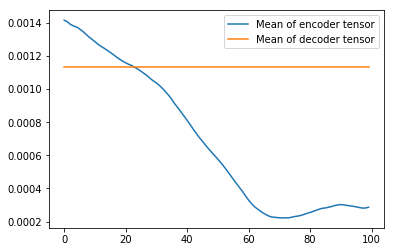

In [7]:
train_encoder.run(BATCH_SIZE, shuffle=True, n_iters = 100, bar=True, drop_last=True)

We can see encoder training changes of encoder tensor mean and we see that  mean of decoder tensor has not changes, because we change only weights from scope of `'encoder'` train step.

Now we have the neural network with trained weights from scope of `'encoder'` train step.

Next we train weights from scope `'decoder'` train step.

In [8]:
train_decoder = (Pipeline(config=config)
                  .init_variable('encoder_tensor', [])
                  .init_variable('decoder_tensor', [])
                  .import_model('conv_nn', train_encoder)
                  .to_array()
                  .train_model('conv_nn', fetches=['body/encoder/encoder-0/block/layer-3/conv2d_1/Conv2D/ReadVariableOp',
                                                   'body/decoder/decoder-2/block/layer-3/conv2d_12/Conv2D/ReadVariableOp'],
                               train_mode='decoder',
                               images=B.images, masks=B.images,
                               save_to=[V('encoder_tensor', mode='a'), V('decoder_tensor', mode='a')],
                               use_lock=True)) << dataset.train

train_decoder.after.plot_tensor_mean(V('encoder_tensor'), V('decoder_tensor'))

100%|██████████| 100/100 [00:06<00:00, 16.80it/s]


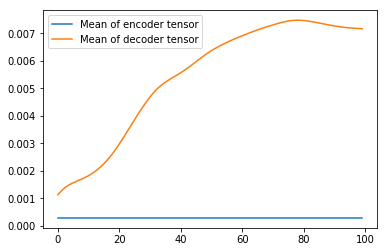

In [9]:
train_decoder.run(BATCH_SIZE, shuffle=True, n_iters=100, bar=True, drop_last=True)

On the second plot we can see that  mean of decoder tensor changes and mean of encoder tensor has not changes (`'decoder'` train step). It means that `train_decoder` pipeline train only decoder part of network.

Now we can get models with different training procedures, and thus we can getting better results.